# Notes


# Load Modules

In [1]:
import os
from optparse import Values

In [2]:
import numpy as np
import pandas as pd

from scipy.stats import spearmanr, pearsonr
from scipy.spatial import Delaunay, distance

In [3]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = 'Arial'
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline

In [4]:
import anndata as ad

# Load data

In [ ]:
%%bash

# rsync -avcP ../../../STdata/merfish_mouse_cortex/cell_label_with_meta.csv.gz merfish_meta.csv
# rsync -avcP ../../../STdata/merfish_mouse_cortex/raw_data/counts.h5ad counts.h5ad


# ONTraC input

In [ ]:
meta_df = pd.read_csv('merfish_meta.csv', index_col=0)
meta_df[['slice_id','subclass','x','y']].to_csv('merfish_input.csv', index=True, index_label='Cell_ID')

# Gen run lsf

- Our HPC using Load Sharing Facility (LSF) Job Scheduler, please modify the following code to fit your own computer.
- Please also modify the path for yourself

In [6]:
run_lsf_dir = '../../run_lsf'

os.makedirs(run_lsf_dir, exist_ok=True)

In [7]:
templete = '''#!/bin/bash
#BSUB -J {name}
#BSUB -n 12
#BSUB -P acc_YuanLab
#BSUB -q gpuexpress
#BSUB -W 4:00
#BSUB -R "rusage[mem=10000] span[hosts=1]"
#BSUB -gpu num=1
#BSUB -R h100nvl

#BSUB -oo log/job_{name}.out
#BSUB -eo log/job_{name}.err

JOBID=$1

source /hpc/users/wangw32/.bash_profile

mkdir -p output log

conda activate ONTraC
ONTraC --meta-input raw_data/merfish_cortex/{meta_input} --NN-dir {NN_dir} --GNN-dir {GNN_dir} --NT-dir {NT_dir} --n-cpu 12 --n-neighbors {n_neighbors} --device cuda --epochs 1000 --batch-size 10 -s 42 --patience 100 --min-delta 0.001 --min-epochs 50 --lr 0.03 --hidden-feats {hidden_feats} --n-gcn-layers {n_gcn_layers} -k {k} --modularity-loss-weight 0.3 --purity-loss-weight 300 --regularization-loss-weight 0.1 --beta 0.03 > log/{name}.log

bjobs -l -gpu $JOBID >log/job_{name}_resource_usage.txt
'''

In [8]:
analysis_templete = '''#!/bin/bash
#BSUB -J {name}_analysis
#BSUB -n 2
#BSUB -P acc_YuanLab
#BSUB -q express
#BSUB -W 2:00
#BSUB -R "rusage[mem=10000] span[hosts=1]"

#BSUB -oo log/job_{name}_analysis.out
#BSUB -eo log/job_{name}_analysis.err

JOBID=$1

source /hpc/users/wangw32/.bash_profile

mkdir -p analysis_output

conda activate ONTraC

ONTraC_analysis --NN-dir {NN_dir} --GNN-dir {GNN_dir} --NT-dir {NT_dir} -o analysis_output/{name} -l log/{name}.log -s --suppress-cell-type-composition
'''

In [ ]:
# ------------------------------------
# Hyper Parameters
# ------------------------------------
test_params = {  # first one is the default
    'meta_input': ['merfish_input.csv'],
    'n_neighbors': [50, 10, 20, 100],
    'hidden_feats': [4, 2, 8, 16],
    'k': [6, 4, 8, 10],
    'n_gcn_layers': [2, 1, 3, 4, 5, 6]
}

In [ ]:
from typing import Dict


def gen_run_lsf(name: str,
                params: Dict,
                template: str,
                output_dir: str):
    written_params = {}

    written_params.update({key: params[key][0] for key in params})  # load default params
    written_params["name"] = f'{name}_base'
    written_params["NN_dir"] = f'output/{written_params["name"]}_NN'
    written_params["GNN_dir"] = f'output/{written_params["name"]}_GNN'
    written_params["NT_dir"] = f'output/{written_params["name"]}_NT'
    with open(f'{output_dir}/{written_params["name"]}_run_lsf.sh', 'w') as f:
        f.write(template.format(**written_params))

    
    for key, value in params.items():
        for index, value_ in enumerate(value[1:]):
            written_params[key] = value_
            written_params["name"] = f'{name}_{key}_{value_}'
            written_params["NN_dir"] = f'output/{written_params["name"]}_NN'
            written_params["GNN_dir"] = f'output/{written_params["name"]}_GNN'
            written_params["NT_dir"] = f'output/{written_params["name"]}_NT'
            with open(f'{output_dir}/{written_params["name"]}_run_lsf.sh', 'w') as f:
                f.write(template.format(**written_params))
        written_params[key] = params[key][0]


gen_run_lsf(name='merfish_cortex',
            params=test_params,
            template=templete,
            output_dir=run_lsf_dir)

In [ ]:
from typing import Dict


def gen_analysis_lsf(name: str,
                params: Dict,
                template: str,
                output_dir: str):
    written_params = {}

    written_params.update({key: params[key][0] for key in params})  # load default params
    written_params["name"] = f'{name}_base'
    written_params["NN_dir"] = f'output/{written_params["name"]}_NN'
    written_params["GNN_dir"] = f'output/{written_params["name"]}_GNN'
    written_params["NT_dir"] = f'output/{written_params["name"]}_NT'
    with open(f'{output_dir}/{written_params["name"]}_analysis_lsf.sh', 'w') as f:
        f.write(template.format(**written_params))
    
    for key, value in params.items():
        for index, value_ in enumerate(value[1:]):
            written_params[key] = value_
            written_params["name"] = f'{name}_{key}_{value_}'
            written_params["NN_dir"] = f'output/{written_params["name"]}_NN'
            written_params["GNN_dir"] = f'output/{written_params["name"]}_GNN'
            written_params["NT_dir"] = f'output/{written_params["name"]}_NT'
            with open(f'{output_dir}/{written_params["name"]}_analysis_lsf.sh', 'w') as f:
                f.write(template.format(**written_params))
        written_params[key] = params[key][0]  # recover to the default


gen_analysis_lsf(name='merfish_cortex',
            params=test_params,
            template=analysis_templete,
            output_dir=run_lsf_dir)

# metric

## prepare

In [42]:
input_df = pd.read_csv('merfish_meta.csv', index_col=0)
old_columns = input_df.columns.tolist()
old_columns[old_columns.index('slice_id')] = 'Sample'
input_df.columns = old_columns
input_df.head()

,sample_id,Sample,class_label,subclass,label,x,y,cortical_depth,extra_annot,leiden_res_10.00,leiden_res_30.00
index,,,,,,,,,,,
10000143038275111136124942858811168393,mouse2_sample4,mouse2_slice31,Other,Astro,Astro_1,4738.402723,3075.604074,888.114748,Astro,0,245
100001798412490480358118871918100400402,mouse2_sample5,mouse2_slice160,Other,Endo,Endo,-3965.470904,1451.943297,1449.123485,Endo,8,206
100006878605830627922364612565348097824,mouse2_sample6,mouse2_slice109,Other,SMC,SMC,805.848948,1215.458623,22.943763,SMC,39,174
100007228202835962319771548915451072492,mouse1_sample2,mouse1_slice71,Other,Endo,Endo,1347.655448,-3589.803355,1086.621925,Endo,10,177
100009332472089331948140672873134747603,mouse2_sample5,mouse2_slice219,Glutamatergic,L2/3 IT,L23_IT_3,-3584.216904,-1883.214455,308.178627,L2/3 IT,59,61


In [43]:
input_df.shape

(280186, 11)

## results

In [ ]:
def get_results_sample(values, cortical_depth, adj_matrix):
    corr = abs(spearmanr(values, cortical_depth)[0])
    return corr
    

In [ ]:
samples = input_df['Sample'].unique().tolist()


def get_results_df():
    written_params = {}
    written_params.update({key: values[0] for key, values in test_params.items()})
    run_name = 'merfish_cortex_base'
    NTScore_df = pd.read_csv(f'../../output/{run_name}_NT/NTScore.csv.gz', index_col=0)
    NTScore_df = NTScore_df.join(input_df[['cortical_depth','Sample']])
    for sample in samples:
        sample_df = NTScore_df[NTScore_df['Sample']==sample]
        adj_matrix = cal_delaunay_net_edges(sample_df[['x', 'y']].values)
        corr = get_results_sample(
            sample_df['Cell_NTScore'].values,
            sample_df['cortical_depth'].values,
            adj_matrix)
        yield run_name, sample, 'ONTraC', 'base', written_params['meta_input'], written_params['n_neighbors'], written_params['hidden_feats'], written_params['k'], written_params['n_gcn_layers'], corr#, moran_I

    for key, value in test_params.items():
        for index, value_ in enumerate(value[1:]):
            written_params[key] = value_
            if key == 'meta_input':
                written_params["name"] = f'merfish_cortex_{key}_{index+1}'
            else:
                written_params["name"] = f'merfish_cortex_{key}_{value_}'
            run_name = f'{written_params["name"]}'
            NTScore_df = pd.read_csv(f'../../output/{run_name}_NT/NTScore.csv.gz', index_col=0)
            NTScore_df = NTScore_df.join(input_df[['cortical_depth','Sample']])
            for sample in samples:
                sample_df = NTScore_df[NTScore_df['Sample']==sample]
                adj_matrix = cal_delaunay_net_edges(sample_df[['x', 'y']].values)
                corr = get_results_sample(
                    sample_df['Cell_NTScore'].values,
                    sample_df['cortical_depth'].values,
                    adj_matrix)
                yield run_name, sample, 'ONTraC', key, written_params['meta_input'], written_params['n_neighbors'], written_params['hidden_feats'], written_params['k'], written_params['n_gcn_layers'], corr#, moran_I
        written_params[key] = test_params[key][0]  # recover to the default

results_df = pd.DataFrame(get_results_df(),
                          columns = ['run_name', 'sample', 'Method', 'Params', 'meta_input', 'n_neighbors', 'hidden_feats', 'k', 'n_gcn_layers', 'correlation'])
results_df.head()


,run_name,sample,Method,Params,meta_input,n_neighbors,hidden_feats,k,n_gcn_layers,correlation
0,merfish_cortex_base,mouse2_slice31,ONTraC,base,merfish_input.csv,50,4,6,2,0.986163
1,merfish_cortex_base,mouse2_slice160,ONTraC,base,merfish_input.csv,50,4,6,2,0.958468
2,merfish_cortex_base,mouse2_slice109,ONTraC,base,merfish_input.csv,50,4,6,2,0.913865
3,merfish_cortex_base,mouse1_slice71,ONTraC,base,merfish_input.csv,50,4,6,2,0.955667
4,merfish_cortex_base,mouse2_slice219,ONTraC,base,merfish_input.csv,50,4,6,2,0.975969


In [23]:
results_df

,run_name,sample,Method,Params,meta_input,n_neighbors,hidden_feats,k,n_gcn_layers,correlation
0,merfish_cortex_base,mouse2_slice31,ONTraC,base,merfish_input.csv,50,4,6,2,0.986163
1,merfish_cortex_base,mouse2_slice160,ONTraC,base,merfish_input.csv,50,4,6,2,0.958468
2,merfish_cortex_base,mouse2_slice109,ONTraC,base,merfish_input.csv,50,4,6,2,0.913865
3,merfish_cortex_base,mouse1_slice71,ONTraC,base,merfish_input.csv,50,4,6,2,0.955667
4,merfish_cortex_base,mouse2_slice219,ONTraC,base,merfish_input.csv,50,4,6,2,0.975969
...,...,...,...,...,...,...,...,...,...,...
1147,merfish_cortex_n_gcn_layers_6,mouse2_slice70,ONTraC,n_gcn_layers,merfish_input.csv,50,4,6,6,0.993368
1148,merfish_cortex_n_gcn_layers_6,mouse2_slice40,ONTraC,n_gcn_layers,merfish_input.csv,50,4,6,6,0.990937
1149,merfish_cortex_n_gcn_layers_6,mouse1_slice260,ONTraC,n_gcn_layers,merfish_input.csv,50,4,6,6,0.002861
1150,merfish_cortex_n_gcn_layers_6,mouse2_slice261,ONTraC,n_gcn_layers,merfish_input.csv,50,4,6,6,0.591870


In [24]:
results_df.to_csv('metrics.csv')

## base

In [46]:
run_name = 'merfish_cortex_base'
NTScore_df = pd.read_csv(f'../../output/{run_name}_NT/NTScore.csv.gz', index_col=0)
NTScore_df = NTScore_df.join(input_df[['cortical_depth','Sample', 'extra_annot']])
NTScore_df.head()


,x,y,Niche_NTScore,Cell_NTScore,cortical_depth,Sample,extra_annot
Cell_ID,,,,,,,
10000143038275111136124942858811168393,4738.402723,3075.604074,0.398701,0.398146,888.114748,mouse2_slice31,Astro
100091152035772192874698518269494521268,4319.030049,2628.021401,0.601356,0.611682,519.891790,mouse2_slice31,L4/5 IT
100318785722691998123111916762029843183,4486.534300,2004.802524,0.802234,0.827713,161.722279,mouse2_slice31,Endo
100341059438931731510635049259352883335,4464.074801,3432.480751,0.506373,0.494413,593.476063,mouse2_slice31,L4/5 IT
101059342090754465645773829438399819266,4127.878468,2366.196146,0.801902,0.827421,200.021444,mouse2_slice31,L2/3 IT


In [47]:
NTScore_df['extra_annot'].unique().tolist()

['Astro',
 'L4/5 IT',
 'Endo',
 'L2/3 IT',
 'L5 IT',
 'L5/6 NP',
 'L5 ET',
 'OPC',
 'Oligo',
 'VLMC',
 'Micro',
 'SMC',
 'Peri',
 'L6 IT',
 'Lamp5',
 'PVM',
 'Sst',
 'Pvalb',
 'L6 IT Car3',
 'L6 CT',
 'Vip',
 'L6b',
 'Sncg',
 'other',
 'non-layer VLMC']

In [57]:
data_df = input_df.join(NTScore_df['Cell_NTScore'])

In [63]:
data_df['Cell_NTScore_r'] = 1- data_df['Cell_NTScore']

In [74]:
data_df['norm_cortical_depth'] = (data_df['cortical_depth'] - data_df['cortical_depth'].min()) / (data_df['cortical_depth'].max() - data_df['cortical_depth'].min())


In [58]:
cell_types = data_df['subclass'].unique().tolist()

In [59]:
selected_cell_types = ["VLMC", 'L2/3 IT', 'L4/5 IT', 'L5 IT',"L5 ET", "L5/6 NP" , 'L6 IT',"L6 CT","L6 IT Car3"]



rainbow_cmap = mpl.colormaps['gist_rainbow']

my_pal = {"VLMC": rainbow_cmap(0)}
my_pal.update({cell_type: rainbow_cmap( 0.3 + 0.7 * (i - 1) / (len(selected_cell_types) - 1)) for i, cell_type in enumerate(selected_cell_types[1:])})
my_pal.update({cell_type: 'gray' for cell_type in cell_types if cell_type not in selected_cell_types})


my_pal_sub = {k: v for k, v in my_pal.items() if k in selected_cell_types}

In [84]:
import os
import warnings

os.makedirs('figures', exist_ok=True)
warnings.filterwarnings('ignore')

c_depth_cor_all_cells_dict = {}


with sns.axes_style('white', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 8,
                             'axes.labelsize': 8,
                             'xtick.labelsize': 6,
                             'ytick.labelsize': 6,
                             'legend.fontsize': 6
                         }):
    for sample in samples:
        print(sample)
        sample_df = data_df[data_df['Sample'] == sample]
        if sample_df.shape[0] == 0:
            continue
        fig, ax = plt.subplots(figsize=(4.2, 3.5))
        sns.scatterplot(data = sample_df,
                        x = 'norm_cortical_depth',
                        # y = 'Cell_NTScore',
                        y = 'Cell_NTScore_r',
                        hue='subclass',
                        palette=my_pal,
                        s = 4,
                        edgecolor = None,
                        ax = ax)
        # ax.set_xlim(0, 1)
        # ax.set_ylim(0, 1)
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title = 'cell type')
        ax.set_xlabel('Normalized cortical depth')
        ax.set_ylabel('cell-level NT score')
        # cor = spearmanr(sample_df['c_depth'], sample_df['Cell_NTScore'], nan_policy='omit')[0]
        cor = spearmanr(sample_df['norm_cortical_depth'], sample_df['Cell_NTScore_r'], nan_policy='omit')[0]
        c_depth_cor_all_cells_dict[sample] = cor
        ax.annotate(text = f'Corr = {cor:.2f}', xy = (0.1, 0.9), xycoords = 'axes fraction', color = 'r')
        fig.tight_layout()
        fig.savefig(f'figures/scatter_{sample}_cor_cortical_depth_all_cells.pdf', transparent=False)
        plt.close(fig)
    

mouse2_slice31
mouse2_slice160
mouse2_slice109
mouse1_slice71
mouse2_slice219
mouse2_slice289
mouse1_slice313
mouse2_slice309
mouse1_slice153
mouse1_slice201
mouse2_slice61
mouse1_slice40
mouse1_slice1
mouse2_slice1
mouse2_slice151
mouse1_slice102
mouse1_slice162
mouse1_slice221
mouse1_slice200
mouse2_slice300
mouse2_slice90
mouse1_slice283
mouse1_slice326
mouse2_slice209
mouse1_slice50
mouse1_slice112
mouse1_slice212
mouse1_slice271
mouse2_slice119
mouse1_slice291
mouse2_slice169
mouse1_slice31
mouse2_slice280
mouse1_slice232
mouse1_slice10
mouse1_slice241
mouse1_slice251
mouse2_slice99
mouse1_slice190
mouse2_slice319
mouse2_slice189
mouse1_slice81
mouse2_slice249
mouse2_slice139
mouse1_slice21
mouse2_slice129
mouse2_slice79
mouse2_slice229
mouse1_slice131
mouse1_slice122
mouse1_slice62
mouse2_slice270
mouse2_slice10
mouse1_slice180
mouse1_slice170
mouse1_slice91
mouse2_slice50
mouse1_slice301
mouse2_slice201
mouse2_slice70
mouse2_slice40
mouse1_slice260
mouse2_slice261
mouse2_slice20

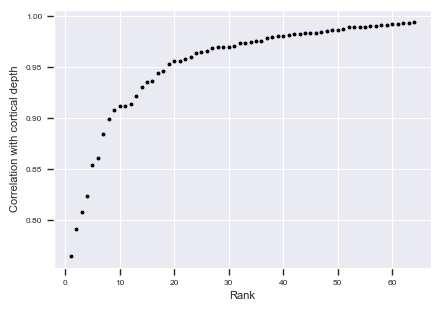

In [76]:
corrs = sorted(list(c_depth_cor_all_cells_dict.values()))
with sns.axes_style('darkgrid', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 8,
                             'axes.labelsize': 8,
                             'xtick.labelsize': 6,
                             'ytick.labelsize': 6,
                             'legend.fontsize': 6
                         }):
    fig, ax = plt.subplots(figsize=(4.5, 3.2))
    ax.scatter(x = np.arange(len(corrs)) + 1, y = corrs, color = 'black', s=4)
    ax.set_xlabel('Rank')
    ax.set_ylabel('Correlation with cortical depth')
    fig.tight_layout()
    fig.savefig('figures/cortial_depth_correlation_all_cells_summary.pdf', transparent=False)

In [77]:
c_depth_cor_all_cells_dict = {}
for index, line in results_df[results_df['Params']=='base'].iterrows():
    c_depth_cor_all_cells_dict[line['sample']] = line['correlation']

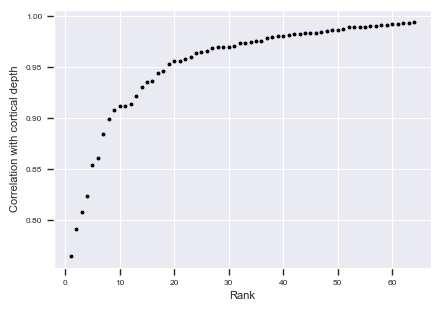

In [78]:
corrs = sorted(list(c_depth_cor_all_cells_dict.values()))
with sns.axes_style('darkgrid', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 8,
                             'axes.labelsize': 8,
                             'xtick.labelsize': 6,
                             'ytick.labelsize': 6,
                             'legend.fontsize': 6
                         }):
    fig, ax = plt.subplots(figsize=(4.5, 3.2))
    ax.scatter(x = np.arange(len(corrs)) + 1, y = corrs, color = 'black', s=4)
    ax.set_xlabel('Rank')
    ax.set_ylabel('Correlation with cortical depth')
    fig.tight_layout()
    fig.savefig('cortial_depth_correlation_all_cells_summary.pdf', transparent=False)

In [79]:
from scipy.stats import rankdata

c_depth_cor_all_cells_df = pd.DataFrame({'sample': list(c_depth_cor_all_cells_dict.keys()),
                               'correlation': list(c_depth_cor_all_cells_dict.values())
                              })
c_depth_cor_all_cells_df.head()

,sample,correlation
0,mouse2_slice31,0.986163
1,mouse2_slice160,0.958468
2,mouse2_slice109,0.913865
3,mouse1_slice71,0.955667
4,mouse2_slice219,0.975969


In [80]:
c_depth_cor_all_cells_df['rank'] = rankdata(c_depth_cor_all_cells_df['correlation'])

In [81]:
c_depth_cor_all_cells_df.sort_values('rank').head(20)

,sample,correlation,rank
37,mouse2_slice99,0.764635,1.0
16,mouse1_slice162,0.791031,2.0
46,mouse2_slice79,0.808410,3.0
54,mouse1_slice170,0.823535,4.0
44,mouse1_slice21,0.854485,5.0
48,mouse1_slice131,0.861034,6.0
53,mouse1_slice180,0.884357,7.0
38,mouse1_slice190,0.899518,8.0
28,mouse2_slice119,0.907648,9.0
45,mouse2_slice129,0.911924,10.0


In [82]:
c_depth_cor_all_cells_df.sort_values('rank').head(32).tail()

,sample,correlation,rank
32,mouse2_slice280,0.969525,28.0
17,mouse1_slice221,0.969952,29.0
26,mouse1_slice212,0.970058,30.0
15,mouse1_slice102,0.970659,31.0
30,mouse2_slice169,0.973321,32.0


In [83]:
c_depth_cor_all_cells_df.sort_values('rank').tail(20)

,sample,correlation,rank
21,mouse1_slice283,0.983508,45.0
43,mouse2_slice139,0.983786,46.0
58,mouse2_slice201,0.984872,47.0
22,mouse1_slice326,0.985159,48.0
0,mouse2_slice31,0.986163,49.0
35,mouse1_slice241,0.986384,50.0
62,mouse2_slice261,0.987775,51.0
55,mouse1_slice91,0.989057,52.0
34,mouse1_slice10,0.989681,53.0
29,mouse1_slice291,0.989784,54.0
